# A Vector Approach to Drainage Network Analysis Based on LiDAR Data

Author: Fangzheng Lyu

Email: flu8@illinois.edu

Fangzheng Lyu, Zewei Xu, Xinlin Ma, Shaohua Wang, Zhiyu Li, Shaowen Wang. (Second round review). A Vector-Based Method for Drainage Network Analysis Based on LiDAR Data. Computer and Geoscience.

This notebook is designed for the manuscript "A Vector Approach to Drainage Network Analysis Based on LiDAR Data". The algorithm is implemented here in this jupyter notebook. This is a  sample notebook used for a small small dataset which is 10 pixels*10 pixels for the LiDAR data. 

## Table of Contents
* [Psudocode](#psudocode)
* [Set up](#chapter1)
    * [Import Library](#section_1_1)
    * [Set up input variables](#section_1_2)
    * [Read LiDAR data using laspy](#section_1_3)
* [Create a hash table](#chapter2)
* [Elevation Function](#chapter3)
* [Simulate the water flow](#chapter4)
    * [Track the flow direction](#section_4_1)
* [Visulization](#chapter5)

## Psudocode <img src="Picture1.png">

## Set up <a class="anchor" id="chapter1"></a>
The Library used for in the algorithm is set up here

### Import Library <a class="anchor" id="section_1_1"></a>

In [18]:
import datetime
import laspy
import numpy as np
import pandas as pd
from numpy.linalg import inv
import math
import datetime
import sys

2021-02-26 23:43:10.190281


### Set up input variables <a class="anchor" id="section_1_2"></a>

In [2]:
## var1 is the starting location in the x-axis
## var2 is the starting location in the y-axis
## var3 is the angle different we want
var1 = 5
var2 = 5
var3 = 30

### Read LiDAR data using laspy <a class="anchor" id="section_1_3"></a>

In [3]:
## Store the LiDAR data as infile
infile = laspy.file.File("./3_2.las", mode="r")
## Get the value for x axis, y axis, and elevation for LiDAR point cloud
ground_x = infile.x
ground_y = infile.y
ground_z = infile.z
## Normalize the output for the LiDAR file
ground_x_2=ground_x-ground_x.min()
ground_y_2=ground_y-ground_y.min()

The total amount of LiDAR point in the LiDAR file

In [5]:
len(ground_z)

5546582

The x, y, z value for points in the LiDAR file are stored

In [6]:
x = ground_x_2
y = ground_y_2
z = ground_z


Use a dictionary to store the datset

In [7]:
threedarray = np.vstack((x,y,z)).T
dictionary=pd.Series(threedarray.tolist(), index=map(lambda a: round(a,2), x.tolist()))

An example of the format of the dataset

In [8]:
dictionary[1.11]

1.11     [1.1100000001, 238.38, 690.64]
1.11     [1.1100000001, 357.63, 691.02]
1.11     [1.1100000001, 493.72, 695.84]
1.11     [1.1100000001, 510.03, 695.94]
1.11     [1.1100000001, 543.79, 694.55]
1.11     [1.1100000001, 608.59, 694.42]
1.11     [1.1100000001, 668.15, 698.37]
1.11     [1.1100000001, 804.56, 698.38]
1.11     [1.1100000001, 803.46, 698.38]
1.11      [1.1100000001, 795.9, 698.37]
1.11      [1.1100000001, 829.4, 698.32]
1.11     [1.1100000001, 843.54, 697.71]
1.11     [1.1100000001, 850.11, 697.59]
1.11     [1.1100000001, 899.75, 699.48]
1.11     [1.1100000001, 927.99, 699.64]
1.11     [1.1100000001, 1039.51, 699.7]
1.11    [1.1100000001, 1207.29, 703.09]
1.11    [1.1100000001, 1221.25, 704.29]
1.11    [1.1100000001, 1261.16, 707.38]
1.11    [1.1100000001, 1298.14, 707.98]
1.11     [1.1100000001, 1284.09, 707.6]
1.11    [1.1100000001, 1332.92, 708.77]
1.11    [1.1100000001, 1338.14, 708.79]
1.11    [1.1100000001, 1457.17, 711.67]
1.11    [1.1100000001, 1442.11, 711.32]


## Create a hash table data structure to store the LiDAR data <a class="anchor" id="chapter2"></a>

Create the index for each LiDAR data point

In [9]:
list_a=map(lambda a: 10000*int(a), x.tolist())
list_b=map(lambda a: int(a), y.tolist())
index_list=[sum(x) for x in zip(list_a, list_b)]

Generate the hash table and use dictionary data structure to store the dataset

In [11]:
grid_dictionary=pd.Series(threedarray.tolist(), index=index_list)

Get a overview of the dataset

In [20]:
grid_dictionary

16               [0.0200000000186, 16.47, 688.92]
6                    [0.0, 6.80000000005, 688.93]
28                            [0.0, 28.4, 688.96]
280008             [28.01, 8.90000000002, 689.47]
60002       [6.37000000011, 2.28000000003, 689.0]
220000     [22.6000000001, 0.20000000007, 689.09]
260003             [26.97, 3.60999999999, 689.25]
150030             [15.02, 30.5700000001, 689.14]
20008      [2.01000000001, 8.82999999996, 689.13]
290027                     [29.29, 27.28, 689.18]
300013                     [30.29, 13.24, 689.53]
360023             [36.6899999999, 23.08, 689.73]
70004       [7.6100000001, 4.59999999998, 689.34]
350017                     [35.45, 17.42, 689.84]
220033              [22.53, 33.6800000001, 689.1]
120036             [12.9000000001, 36.03, 689.14]
80000     [8.53000000003, 0.290000000037, 689.32]
290021              [29.1100000001, 21.91, 689.2]
40016        [4.1100000001, 16.4400000001, 689.3]
90023              [9.69999999995, 23.08, 689.27]


## Function to find the elevation  <a class="anchor" id="chapter3"></a>

This is the function used in the algorithm to find the elevation of any given point (x, y) using bilinear interpolation.

In [12]:
def find_elevation_new(x, y):
    #bilinear interpolation
    storage = []
    curr_index = 10000*int(x)+int(y)
    diff= 0
    while(len(storage)<4):
        ## Find all the data within the nearby grid
        temp = []
        
        for i in range(int(x-diff), int(x+diff+1)):
            for j in range(int(y-diff), int(y+diff+1)):
                if (i==int(x-diff) or i==int(x+diff) or j==int(y-diff) or j==int(y+diff)):
                    try:
                        rt = grid_dictionary[10000*i+j]
                        if (type(rt)==list):
                            temp.append(rt)
                        else:
                            for it in range(0,len(rt)):
                                temp.append(rt[it])
                    except:
                        useless=1
        temp.sort(key=lambda e: (e[0]-x)*(e[0]-x)+(e[1]-y)*(e[1]-y))
        if (len(storage)+len(temp)<=4):
            ## add them
            for i in range(0,len(temp)):
                storage.append(temp[i])
        else:
            k=0
            while(len(storage)!=4):
                storage.append(temp[k])
                k=k+1
        diff = diff+1
    new_storage = storage[:4]
    a=[[1,new_storage[0][0],new_storage[0][1],new_storage[0][0]*new_storage[0][1]],
       [1,new_storage[1][0],new_storage[1][1],new_storage[1][0]*new_storage[1][1]],
       [1,new_storage[2][0],new_storage[2][1],new_storage[2][0]*new_storage[2][1]],
       [1,new_storage[3][0],new_storage[3][1],new_storage[3][0]*new_storage[3][1]]]
    b=[new_storage[0][2], new_storage[1][2], new_storage[2][2],new_storage[3][2]]
    try:
        ## Conduct bilinear interpolation
        coef_matrix = np.matmul(inv(a), b)
        rt = coef_matrix[0]+coef_matrix[1]*x+coef_matrix[2]*y+coef_matrix[3]*x*y
        return rt
    except:
        return 10000

## Simulate the water flow <a class="anchor" id="chapter4"></a>
This is the major step in the algorithm that is used for simulation of the water flow.

In [13]:
## The area_length variable here represents how large the area the users want to calculate.
area_length = 10

## Print the current time before the execution of the algorithm
print(datetime.datetime.now())
min_x = var1*100
min_y = var2*100
max_x = var1*100+area_length
max_y = var2*100+area_length
increment = 1
angle = var3
x_coord = min_x
y_coord = min_y
rt = []
while x_coord!=(max_x+1):
    while y_coord!=(max_y+1):
        curr_elevation = find_elevation_new(x_coord, y_coord)
        curr_x = x_coord
        curr_y = y_coord
        #print("Starting Point:")
        print((curr_x,curr_y))
        curr_array = []
        while ((curr_x>=min_x and curr_x<=max_x) and (curr_y>=min_y and curr_y<=max_y)):
            #print((curr_x, curr_y, curr_elevation))
            curr_array.append((curr_x, curr_y))
            rt_x = curr_x
            rt_y = curr_y
            rt_elevation = curr_elevation
            angel_diff = 0
            while(angel_diff<360):
                new_x = curr_x+increment*math.sin(math.pi/180*angel_diff)
                new_y = curr_y+increment*math.cos(math.pi/180*angel_diff)
                new_elevation = find_elevation_new(new_x, new_y)
                #print((angel_diff,new_x,new_y,new_elevation,rt_x,rt_y,rt_elevation))
                if (new_elevation<rt_elevation):
                    rt_x = new_x
                    rt_y = new_y
                    rt_elevation = new_elevation
                angel_diff = angel_diff+angle
            if (rt_elevation<curr_elevation):
                curr_x = rt_x
                curr_y = rt_y
                curr_elevation = rt_elevation
            else:
                break
        rt.append(curr_array)
        #print("Result For:")
        #print((x_coord,y_coord))
        #print(curr_array)
        y_coord=y_coord+1
    y_coord = min_y
    x_coord=x_coord+1
## Print the end time of the execution
print(datetime.datetime.now())

2021-02-26 23:36:43.062910
(500, 500)
(500, 501)
(500, 502)
(500, 503)
(500, 504)
(500, 505)
(500, 506)
(500, 507)
(500, 508)
(500, 509)
(500, 510)
(501, 500)
(501, 501)
(501, 502)
(501, 503)
(501, 504)
(501, 505)
(501, 506)
(501, 507)
(501, 508)
(501, 509)
(501, 510)
(502, 500)
(502, 501)
(502, 502)
(502, 503)
(502, 504)
(502, 505)
(502, 506)
(502, 507)
(502, 508)
(502, 509)
(502, 510)
(503, 500)
(503, 501)
(503, 502)
(503, 503)
(503, 504)
(503, 505)
(503, 506)
(503, 507)
(503, 508)
(503, 509)
(503, 510)
(504, 500)
(504, 501)
(504, 502)
(504, 503)
(504, 504)
(504, 505)
(504, 506)
(504, 507)
(504, 508)
(504, 509)
(504, 510)
(505, 500)
(505, 501)
(505, 502)
(505, 503)
(505, 504)
(505, 505)
(505, 506)
(505, 507)
(505, 508)
(505, 509)
(505, 510)
(506, 500)
(506, 501)
(506, 502)
(506, 503)
(506, 504)
(506, 505)
(506, 506)
(506, 507)
(506, 508)
(506, 509)
(506, 510)
(507, 500)
(507, 501)
(507, 502)
(507, 503)
(507, 504)
(507, 505)
(507, 506)
(507, 507)
(507, 508)
(507, 509)
(507, 510)
(508,

Print the simulated water flow

In [14]:
print(rt)
    
data = []
for i in range(0,area_length+1):
    data.append([0]*(area_length+1))


[[(500, 500)], [(500, 501)], [(500, 502)], [(500, 503)], [(500, 504)], [(500, 505)], [(500, 506)], [(500, 507)], [(500, 508)], [(500, 509)], [(500, 510)], [(501, 500), (500.0, 500.0)], [(501, 501), (500.5, 501.8660254037844)], [(501, 502), (500.1339745962156, 501.5)], [(501, 503), (500.1339745962156, 502.5)], [(501, 504), (500.0, 504.0)], [(501, 505), (500.5, 504.1339745962156)], [(501, 506), (500.0, 506.0)], [(501, 507), (500.1339745962156, 507.5)], [(501, 508), (500.1339745962156, 508.5)], [(501, 509), (500.1339745962156, 509.5)], [(501, 510)], [(502, 500), (501.0, 500.0), (500.0, 500.0)], [(502, 501), (501.0, 501.0), (500.5, 501.8660254037844)], [(502, 502), (502.5, 501.1339745962156)], [(502, 503), (501.0, 503.0), (500.1339745962156, 502.5)], [(502, 504), (501.1339745962156, 503.5), (500.1339745962156, 503.5)], [(502, 505), (501.5, 504.1339745962156), (500.5, 504.1339745962156)], [(502, 506), (501.1339745962156, 506.5), (500.26794919243116, 507.0)], [(502, 507), (501.1339745962156,

### Track the flow direction <a class="anchor" id="section_4_1"></a>

In [15]:
for i in range(0,len(rt)):
    for j in range(0,len(rt[i])):
        data[int(math.floor(rt[i][j][0]))-var1*100][int(math.floor(rt[i][j][1]))-var2*100]=data[int(math.floor(rt[i][j][0]))-var1*100][int(math.floor(rt[i][j][1]))-var2*100]+1

## Visulization<a class="anchor" id="chapter5"></a>

The result after tracking the water direction

In [22]:
print(data)

[[4, 6, 8, 9, 13, 1, 2, 5, 3, 5, 2], [3, 4, 4, 14, 7, 1, 4, 2, 3, 11, 2], [2, 5, 6, 9, 14, 4, 3, 5, 10, 4, 2], [1, 2, 8, 2, 12, 1, 2, 5, 5, 2, 2], [1, 2, 6, 4, 5, 4, 4, 4, 1, 2, 1], [1, 5, 1, 3, 4, 3, 1, 4, 1, 2, 1], [5, 1, 10, 6, 3, 1, 2, 2, 1, 2, 2], [2, 1, 5, 4, 2, 9, 4, 6, 5, 2, 1], [4, 1, 4, 2, 2, 4, 2, 2, 1, 1, 1], [1, 2, 3, 1, 2, 2, 1, 1, 1, 6, 1], [1, 1, 1, 1, 1, 1, 1, 2, 3, 1, 1]]


Simple visulization of the result, with brighter area having more water flowing through

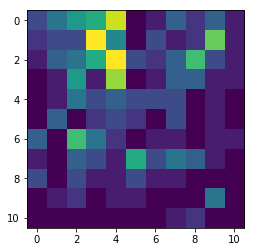

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(data, interpolation='none')
plt.show()